In [1]:
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib
import pybiomart
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io

#also need: igraph, leidenalg, louvain

matplotlib.rcParams.update({'font.size': 12})

# Load in Data
We are using single-cell RNA sequencing (scRNA-seq) data. scRNA-seq is a popular technique for measuring gene expression at the single-cell level.

**The Technique:**
- Individual cells are isolated and captured
- RNA is extracted from each cell, converted to complementary DNA (cDNA), and amplified
- the cDNA libraries are sequenced to generate the transcriptome of each cell - which genes are expressed at at which levels

**The Data:**
- Gene expression matrix: the expression levels of genes in individual cells. Each row is a gene and each column is a cell.
- Barcodes: each cell is associated with a unique barcode that allows researchers to track expression profiles back to specific cells
- Genes: Information about genes detected in the cells (names, identifiers, expression levels)

## [Ischemic Stroke Data](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE174574)

In [2]:
# Load in stroke data sample 1: MCA01

# Load the data into an AnnData object
adata_stroke1 = anndata.read_mtx("stroke_data/GSM5319990_MCAO1_matrix.mtx.gz") # genes by cells matrix

# Read the barcode and gene files
barcodes_stroke1 = pd.read_csv("stroke_data/GSM5319990_MCAO1_barcodes.tsv.gz", header=None)
genes_stroke1 = pd.read_csv("stroke_data/GSM5319990_MCAO1_genes.tsv.gz", header=None)

In [3]:
# Set the barcodes and genes as row and column names for MCA01
adata_stroke1.obs_names = genes_stroke1[0]
adata_stroke1.var_names = barcodes_stroke1[0]

In [4]:
# Transpose the matrix so that it is a cells by genes matrix
adata_stroke1 = adata_stroke1.transpose()
adata_stroke1

AnnData object with n_obs × n_vars = 11772 × 27998

In [5]:
# Load in stroke control data sample 1: sham1

# Load the data into an AnnData object
adata_sham1 = anndata.read_mtx("stroke_data/GSM5319987_sham1_matrix.mtx.gz") # genes by cells matrix

# Read the barcode and gene files
barcodes_sham1 = pd.read_csv("stroke_data/GSM5319987_sham1_barcodes.tsv.gz", header=None)
genes_sham1 = pd.read_csv("stroke_data/GSM5319987_sham1_genes.tsv.gz", header=None)

In [6]:
# Set the barcodes and genes as row and column names for sham1
adata_sham1.obs_names = genes_sham1[0]
adata_sham1.var_names = barcodes_sham1[0]

In [7]:
# Transpose the matrix so that it is a cells by genes matrix
adata_sham1 = adata_sham1.transpose()

# Basic Quality Control
Inspired by https://www.kallistobus.tools/tutorials/kb_getting_started/python/kb_intro_2_python/#examine-the-knee-plot

## Represent the Cells in 2D via Singular Value Decomposition
We're currently working in very high-dimensional gene expression space. We want to transform it to a lower-dimensional space defined by the top singular vectors to capture the most significant patterns of variation while not getting distracted by noise.

SVD decomposes a matrix into 3 matrices:
- U: Left singular vectors, representing the basis vectors for the rows/cells
- S: A diagonal matrix of singular values, which represent the importance of each basis vector for rows/cells
- V: Right singular vectors, representing the basis vectors for columns/genes

We'll use TruncatedSVD, a variant that computes only the top singular vectors, which is more computationally efficient for large matrices.

(PCA, which we saw in class, is a specific application of SVD to the covariance matrix of the data.)

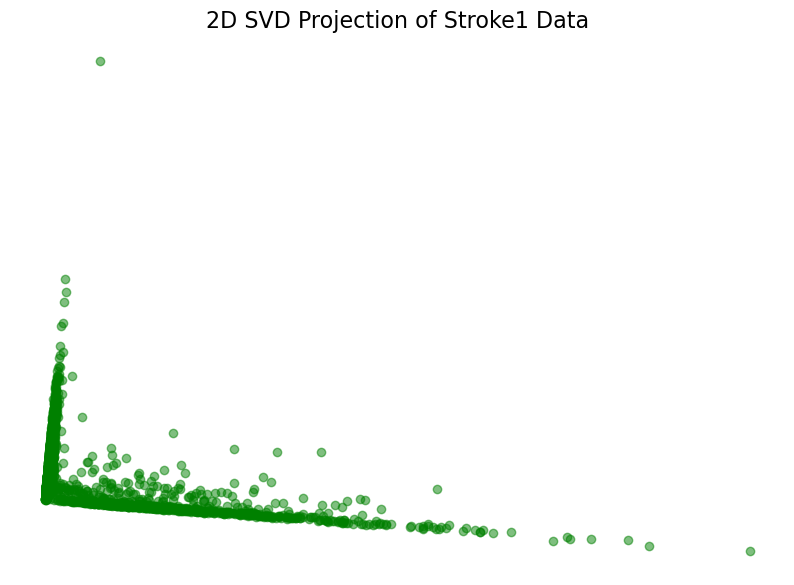

In [8]:
# Perform SVD on Stroke1
tsvd_stroke1 = TruncatedSVD(n_components=2)
tsvd_stroke1.fit(adata_stroke1.X)
X_stroke1 = tsvd_stroke1.transform(adata_stroke1.X)

# Plot Strok1 SVD components
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(X_stroke1[:,0], X_stroke1[:,1], alpha=0.5, c="green")

ax.set_title('2D SVD Projection of Stroke1 Data', fontsize=16)

plt.axis('off')
plt.show()

## Test for Library Saturation
Library saturation is the point at which the sequencing depth is sufficient to capture the majority of expressed genes in each cell. (The point at which increasing the number of transcripts detected in each cell (the unique molecular identifier/UMI counts) does not result in a proportional increase in the number of genes detected.) If we have not "saturated" our sequencing library, then increasing the number of UMI counts (x-axis) will not yield an appreciable increase in the number of genes detected (y-axis).

This is important for quality control because it will help us identify cells with low RNA content or other technical issues, which we should filter out.

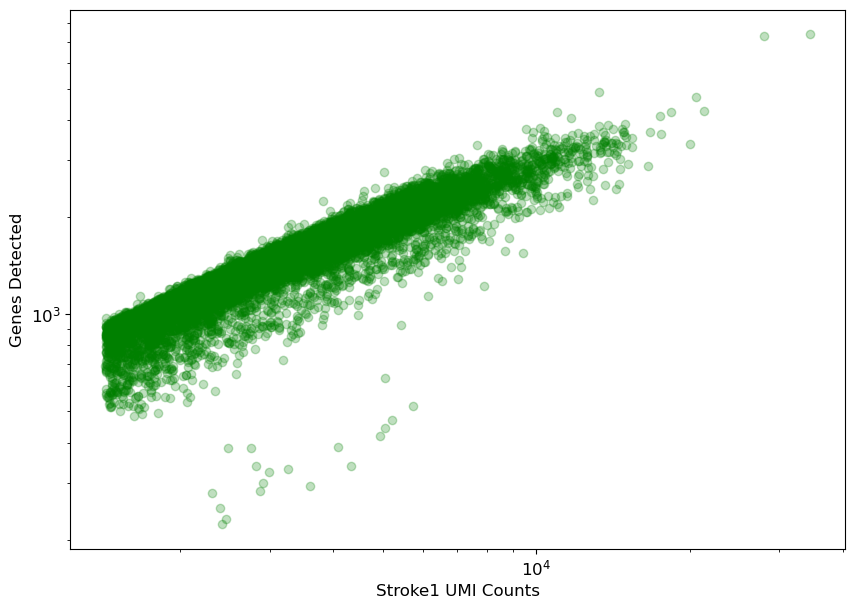

In [9]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

x_stroke1 = np.asarray(adata_stroke1.X.sum(axis=1))[:,0]
y_stroke1 = np.asarray(np.sum(adata_stroke1.X>0, axis=1))[:,0]

ax.scatter(x_stroke1, y_stroke1, color="green", alpha=0.25)
ax.set_xlabel("Stroke1 UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

## Examine the knee plot
"In this plot, cells are ordered by the number of UMI counts associated to them (shown on the x-axis), and the fraction of droplets with at least that number of cells is shown on the y-axis. The idea is that "real" cells have a certain number of UMI counts and that a threshold on the UMI counts filters those cells."

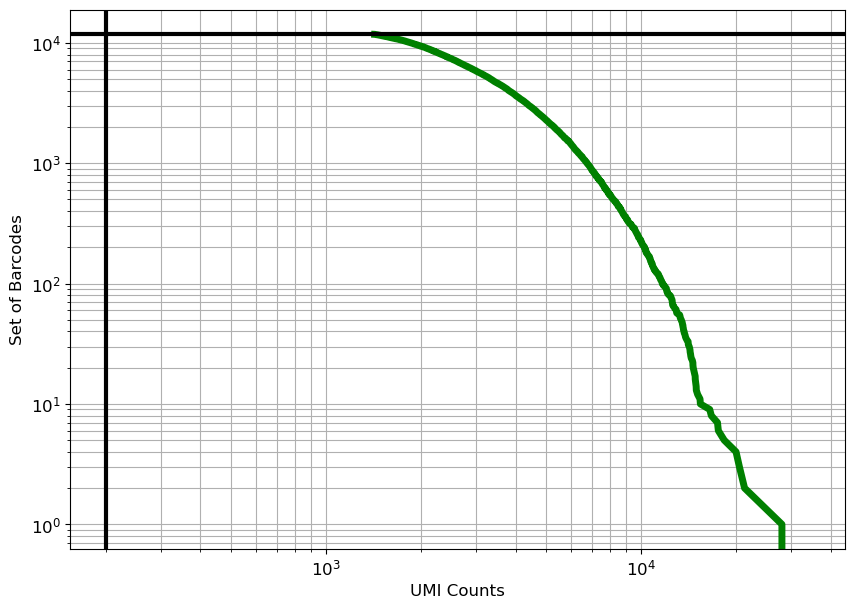

In [10]:
cutoff = 200
knee = np.sort((np.array(adata_stroke1.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")

ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [11]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

11,771 cells passed the 200 UMI threshold


## Filter empty droplets
Filter the cells according to the threshold determined from the knee plot

In [12]:
sc.pp.filter_cells(adata_stroke1, min_genes=200)
# sc.pp.filter_cells(adata_stroke1, min_counts=knee[3704])
adata_stroke1

AnnData object with n_obs × n_vars = 11772 × 27998
    obs: 'n_genes'

## Add n_counts to AnnData obs

In [13]:
# Calculate total counts per cell
total_counts_per_cell = adata_stroke1.X.sum(axis=1).A1

# Add 'n_counts' annotation to obs
adata_stroke1.obs['n_counts'] = total_counts_per_cell

## Filter by Mitochondrial Content
Filter out cells with high mitochondrial content, as this signals apoptotic processes and cellular stress; we also care more about nuclear genome than mitochondrial genome

In [14]:
mito_ensembl_ids = sc.queries.mitochondrial_genes("mmusculus", attrname="ensembl_gene_id")

In [15]:
gene_ids = []
gene_symbols = []

# Separate the gene id from the symbol so we can search by gene id to find cells with mitochondrial genes
for gene_name in adata_stroke1.var_names:
    gene_id, gene_symbol = gene_name.split('\t')
    gene_ids.append(gene_id)
    gene_symbols.append(gene_symbol)
    adata_stroke1.var.loc[gene_name, 'gene_id'] = str(gene_id)
    adata_stroke1.var.loc[gene_name, 'gene_symbol'] = str(gene_symbol)

In [16]:
mito_genes = mito_ensembl_ids["ensembl_gene_id"].values
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)

mito_gene_indices = []
for gene_id in mito_genes:
    indices = np.where(adata_stroke1.var['gene_id'] == gene_id)[0]
    if len(indices) > 0:
        mito_gene_indices.append(indices[0])

adata_stroke1.obs['percent_mito'] = np.sum(
    adata_stroke1[:, mito_gene_indices].X, axis=1).A1 / np.sum(adata_stroke1.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata_stroke1.obs['n_counts'] = adata_stroke1.X.sum(axis=1).A1

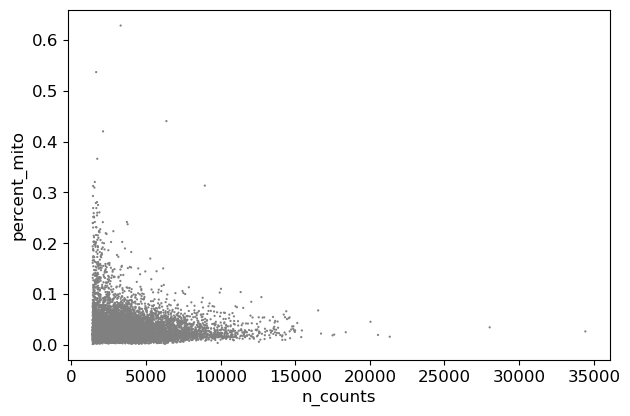

In [17]:
sc.pl.scatter(adata_stroke1, x='n_counts', y='percent_mito')

In [18]:
adata_stroke1 = adata_stroke1[adata_stroke1.obs.percent_mito < 0.03]

## Filter Out Genes Not in Any Cell
Remove genes that have negligible expression across cells to eliminate noise

In [19]:
sc.pp.filter_genes(adata_stroke1, min_cells=3)

/Users/jordan/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:275: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [20]:
adata_stroke1

AnnData object with n_obs × n_vars = 7840 × 16859
    obs: 'n_genes', 'n_counts', 'percent_mito'
    var: 'gene_id', 'gene_symbol', 'n_cells'

## Visualize Count Distributions
Evaluate violin plots for n_genes, n_counts, and percent_mito

/Users/jordan/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


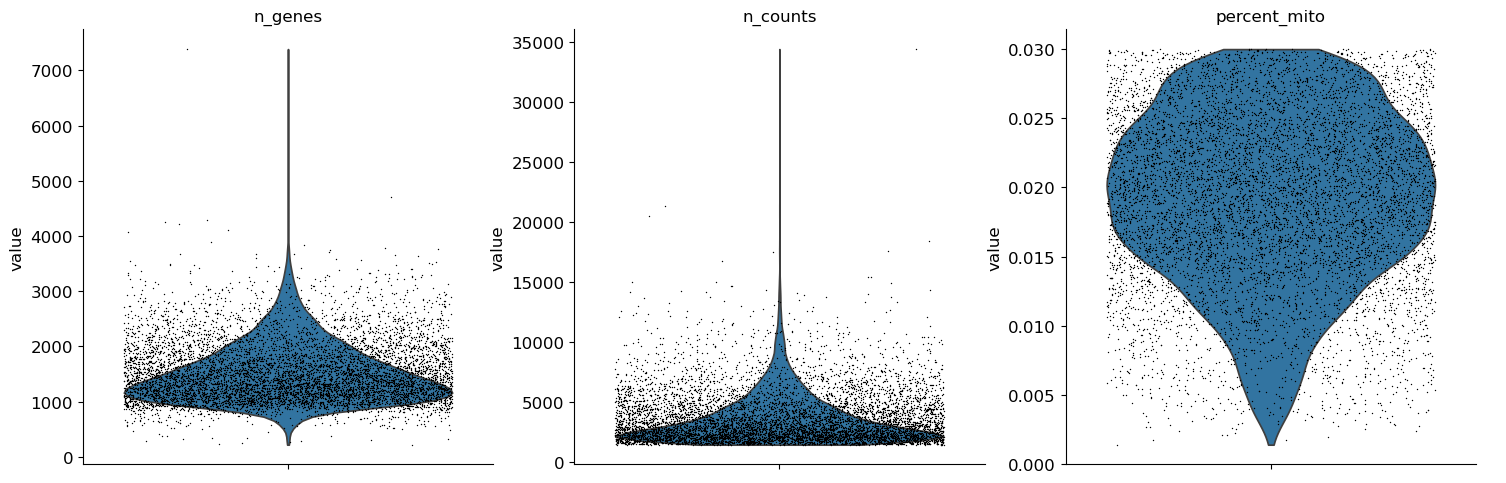

In [21]:
sc.pl.violin(adata_stroke1, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

# Analysis
Inspired by https://www.kallistobus.tools/tutorials/kb_getting_started/python/kb_intro_2_python/#examine-the-knee-plot

## Normalize the Counts

In [22]:
sc.pp.normalize_per_cell(adata_stroke1, counts_per_cell_after=1e4)
sc.pp.log1p(adata_stroke1)

## Identify Highly Variable Genes

/Users/jordan/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:222: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


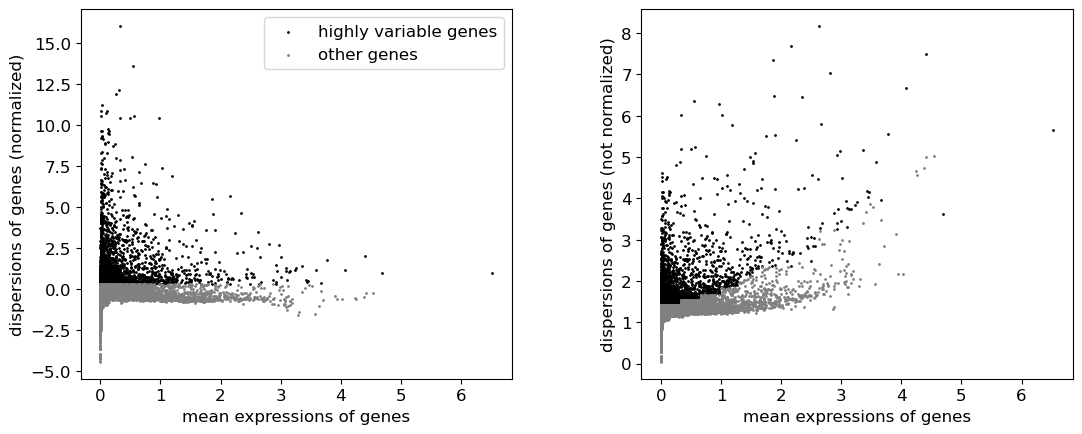

In [23]:
sc.pp.highly_variable_genes(adata_stroke1, min_mean=0.01, max_mean=8, min_disp=1, n_top_genes=3000, n_bins=20, flavor="seurat")
sc.pl.highly_variable_genes(adata_stroke1)

In [24]:
sc.pp.scale(adata_stroke1, max_value=10)

## Clustering & visualization
"Louvain clustering is a popular method for clustering single-cell RNA-seq data. The method was published in

Blondel, Vincent D; Guillaume, Jean-Loup; Lambiotte, Renaud; Lefebvre, Etienne (9 October 2008). "Fast unfolding of communities in large networks". Journal of Statistical Mechanics: Theory and Experiment. 2008 (10): P10008."

In [26]:
sc.tl.pca(adata_stroke1, svd_solver='arpack', use_highly_variable=True, n_comps=10)
sc.pp.neighbors(adata_stroke1, n_neighbors=30, n_pcs=10, knn=True)
sc.tl.louvain(adata_stroke1)

/Users/jordan/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


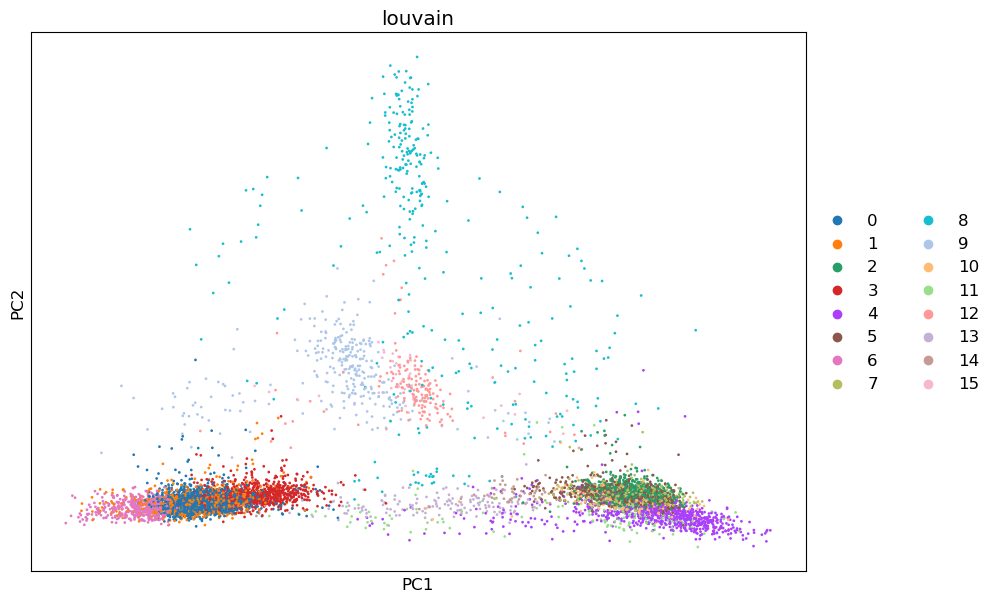

In [27]:
# Perform PCA and plot the projection to the first two dimensions, with points colored according to the Louvain clusters.
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.pca(adata_stroke1, color='louvain', ax=ax)

## Principal Component Analysis Variance Ratio
Determine the extent to which PC1 and PC2 explain the majority of the variance we see in the data

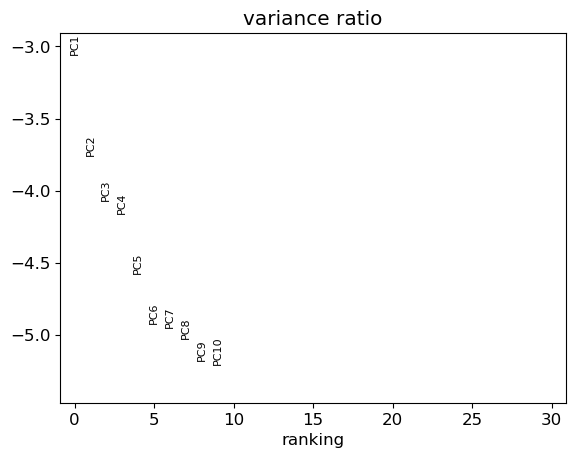

In [28]:
# identify highly variable genes
# sc.pp.highly_variable_genes(adata_stroke1, min_mean=0.01, max_mean=8, min_disp=1, n_top_genes=2000, flavor="cell_ranger", n_bins=20)

# add data structure to adata_stroke1
# sc.pl.highly_variable_genes(adata_stroke1)

# print(adata_stroke1)

# sc.tl.pca(adata_stroke1, svd_solver='arpack', mask_var="highly_variable")

# sc.pl.pca(adata_stroke1)

sc.pl.pca_variance_ratio(adata_stroke1, log=True)

## UMAP
"UMAP stands for Uniform Manifold Approximation and Projection is a non-linear dimensionality reduction techinque described in

Leland McInnes and John Healy and James Melville, "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction" 2018 1802.03426 arXiv stat.ML"

In [29]:
sc.tl.umap(adata_stroke1)

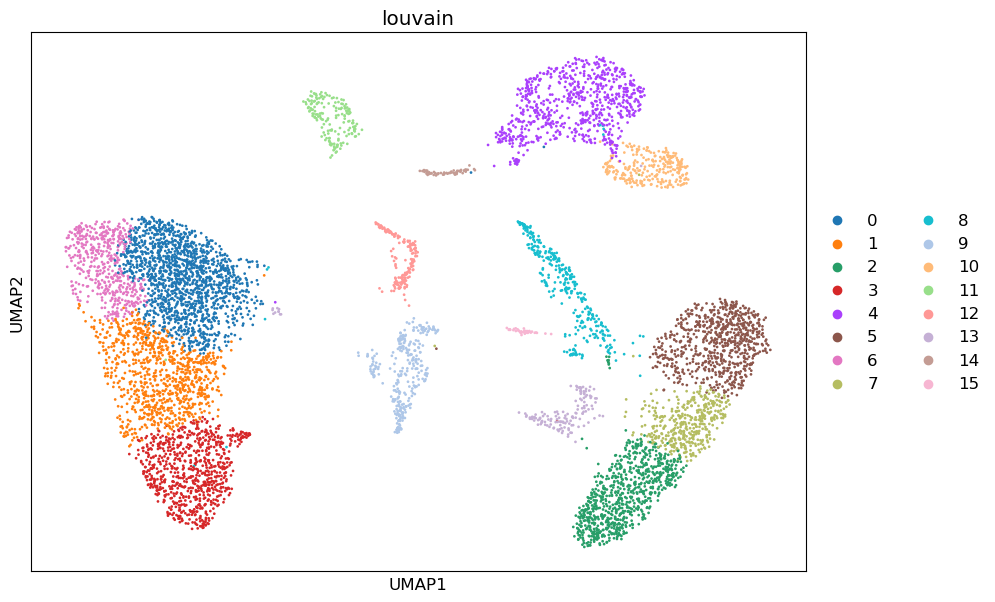

In [30]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata_stroke1, color='louvain', ax=ax)

## Annotation Strategy
Here we will identify genes with differential expression among each cluster, looking to identify
cellular gene markers that may define the cluster as a whole through downstream feature plots.

/Users/jordan/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/jordan/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/jordan/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/jordan/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/jordan/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/jordan/a

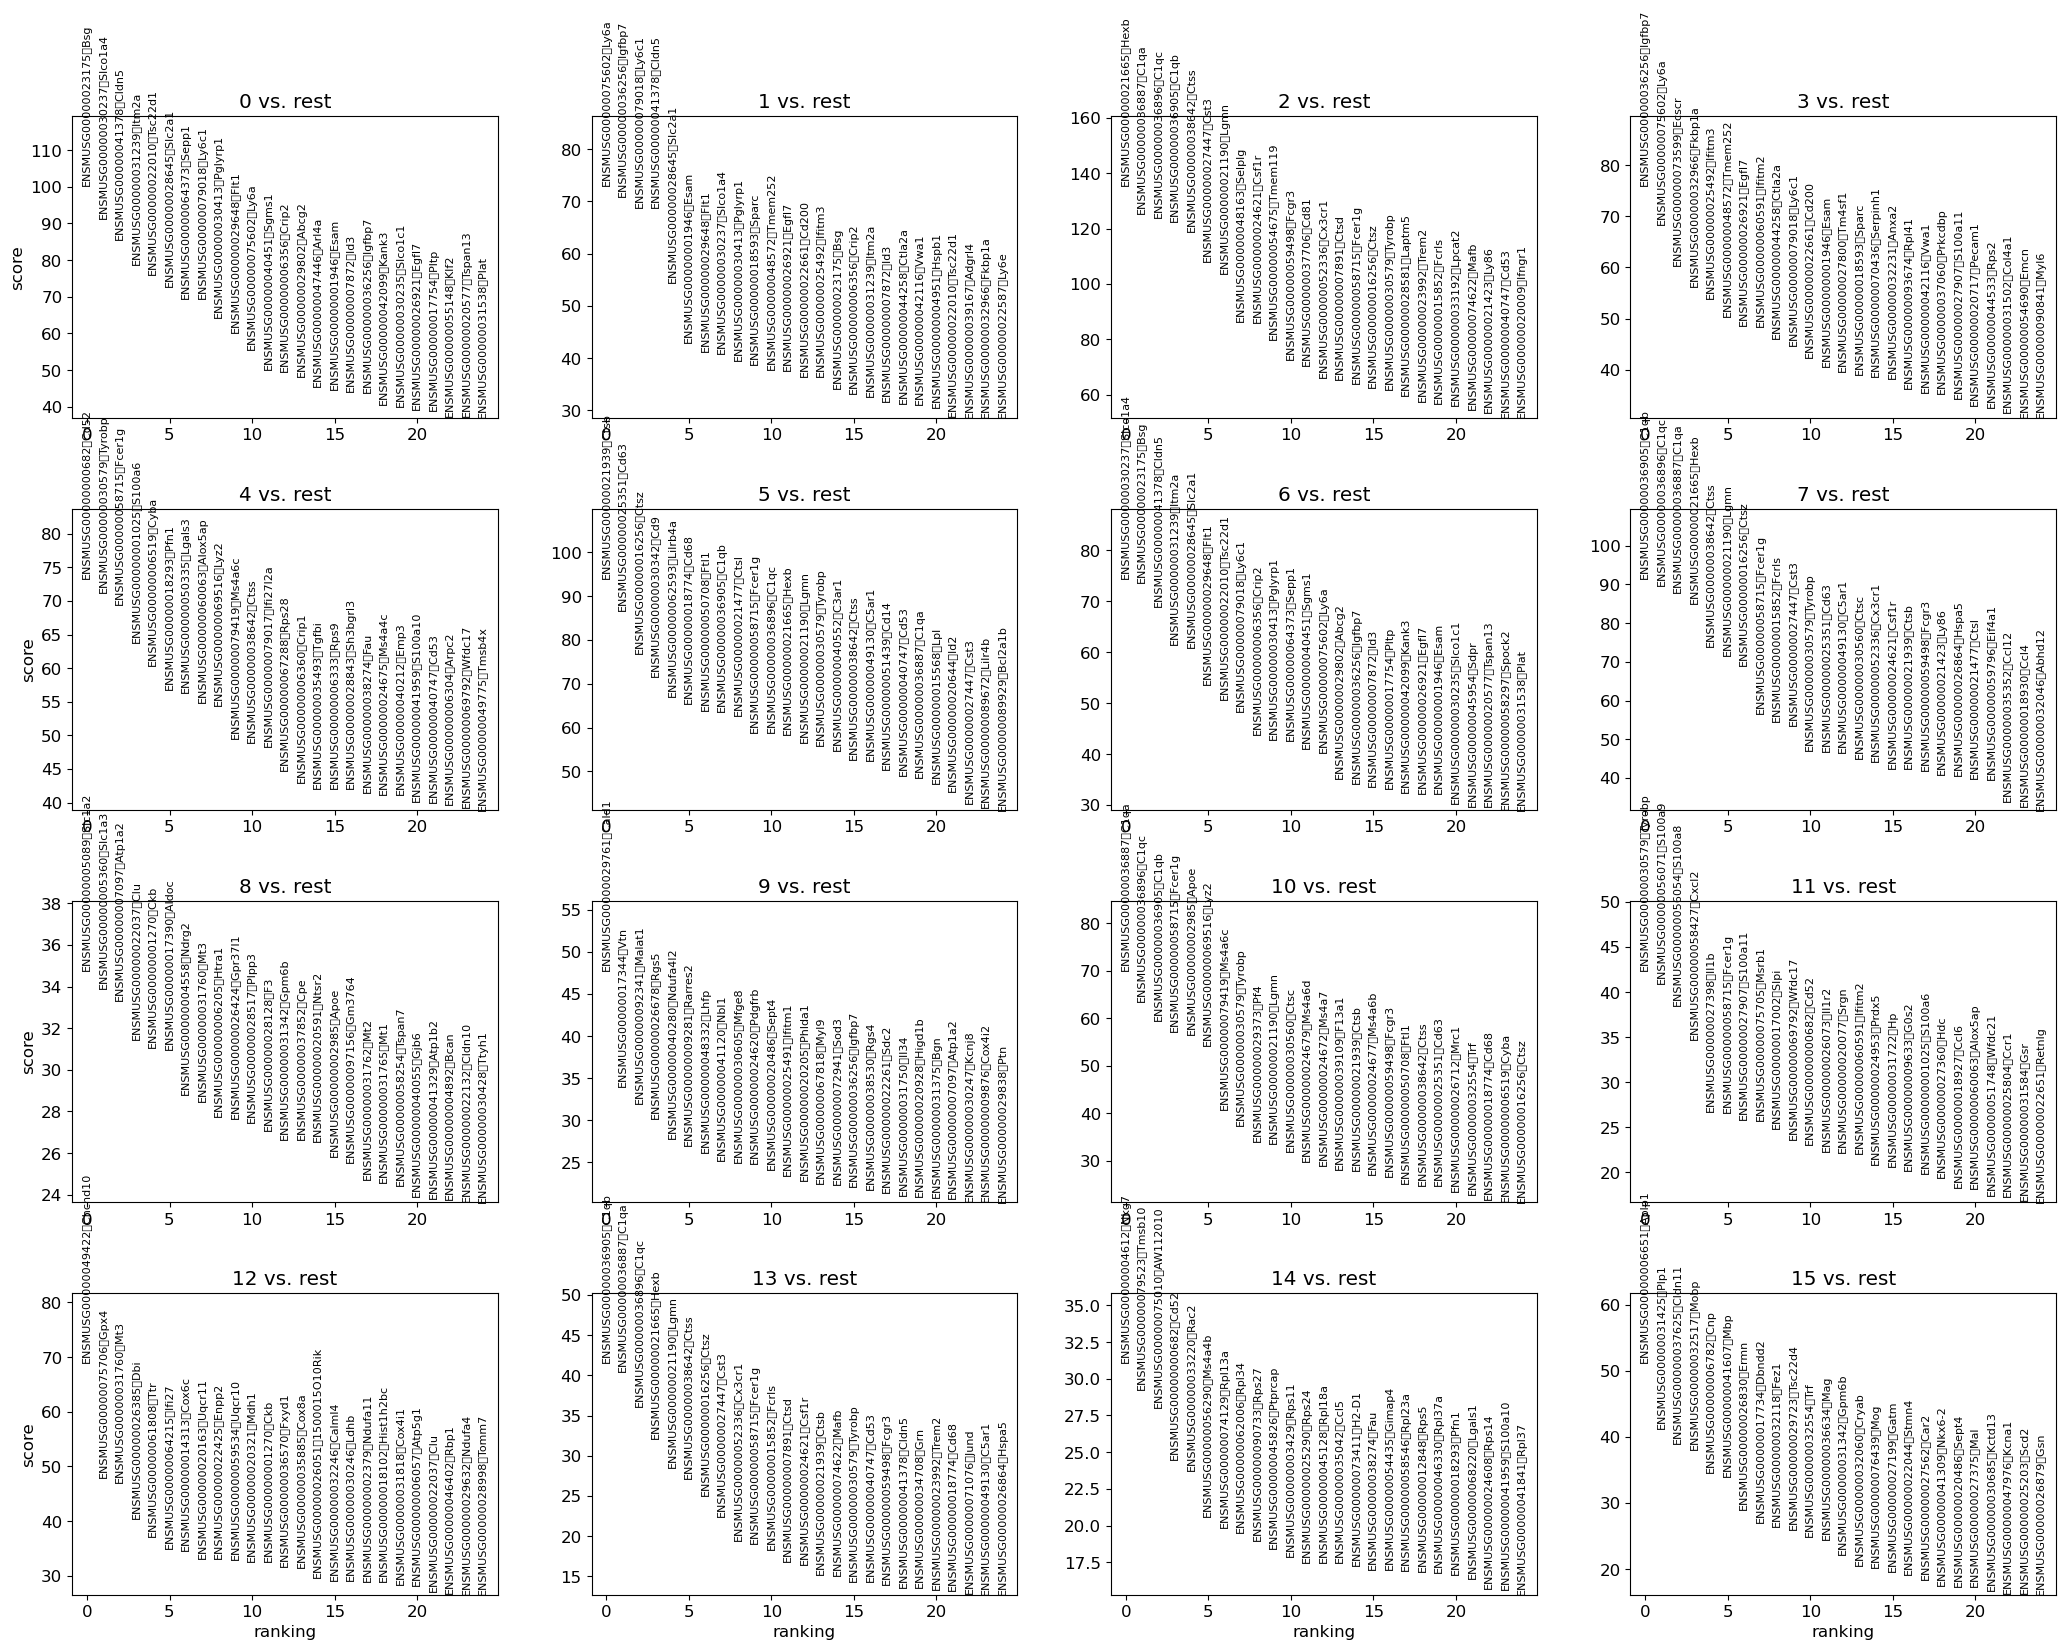

In [35]:
sc.tl.rank_genes_groups(adata_stroke1, 'louvain', method='t-test', corr_method="bonferroni")
sc.pl.rank_genes_groups(adata_stroke1, n_genes=25, sharey=False)